# Robust logistic regression test

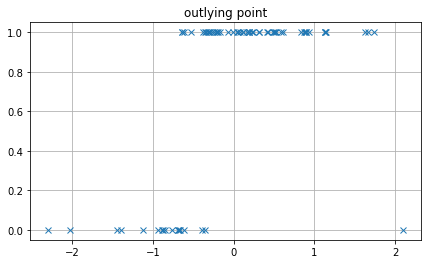

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from MLPR_toolbox.functions import sigmoid
from MLPR_toolbox.preprocessing import make_Phi_polynomial_1d, train_val_test_split

np.random.seed(1)

N = 100
X = np.sort(np.random.normal(size=(N,1)), axis=0)
X = make_Phi_polynomial_1d(X, orders=np.array([0,1]))
w_true = np.array([1,2]).reshape(-1,1)

y = sigmoid(X@w_true) + np.random.normal(scale=0.07, size=(N,1))
y = np.where(y>0.5, 1, 0)
y = np.where(X[:, 1]>1.8, 0, y.flatten())

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y.reshape(-1,1), shares=np.array([0.7,0.29,0.01]), random_state=5)

plt.rc('figure', figsize=(7,4))
plt.plot(X_train[:, 1], y_train, 'x')
plt.title('outlying point')
plt.grid()

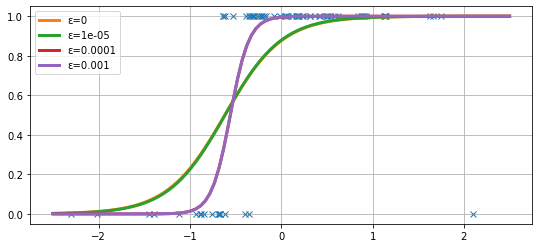

In [7]:
from MLPR_toolbox.regression_models import LogisticRegression

logreg = LogisticRegression(X_train, y_train)
    
supp = np.linspace(-2.5,2.5, 100).reshape(-1,1)
suppX = make_Phi_polynomial_1d(supp, np.arange(2))

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(X_train[:, 1], y_train, 'x')

for eps in [0, 1e-5, 1e-4, 1e-3]:
    fitted = logreg.fit_predict(suppX, eps=eps)
    ax.plot(supp, fitted, label=f'ε={eps}', lw=3)
    
ax.legend()
ax.grid()

# Multiclass classification test

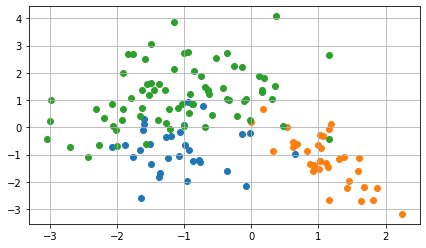

In [2]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

from MLPR_toolbox.preprocessing import train_val_test_split, oneHotEncode

N = 200
K = 3
D = 2
X, y = make_classification(n_samples=N, 
                           n_classes=K, 
                           n_informative=2, 
                           n_features=D, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_clusters_per_class=1, 
                           random_state=5, 
                           weights=np.array([0.2, 0.3, 0.5])
                          )

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y.reshape(-1,1), shares=np.array([0.7,0.29,0.01]), random_state=5)
y_train_oh, y_val_oh, y_test_oh = oneHotEncode(y_train), oneHotEncode(y_val), oneHotEncode(y_test)

fig, ax = plt.subplots(figsize=(7,4))
for c in np.sort(np.unique(y)):
    ax.scatter(X_train[y_train==c, 0], X_train[y_train==c, 1])
ax.grid()

In [3]:
from MLPR_toolbox.functions import multiclass_cross_entropy, softmax        
from scipy.optimize import minimize

def fun(W):
    Y_pred = softmax(X_train, W)
    cost = multiclass_cross_entropy(y_train_oh, Y_pred)
    return cost

D = 2
K = 3
res = minimize(lambda w: fun(w.reshape((K,D))), x0=np.zeros(K*D), method='L-BFGS-B')
W_opt = res['x'].reshape((K,D))

In [4]:
# prediction
y_pred = softmax(X_val, W_opt).argmax(axis=1)

# accuracy
np.sum(y_val==y_pred)/y_pred.size

0.9298245614035088

# Gaussian processes test

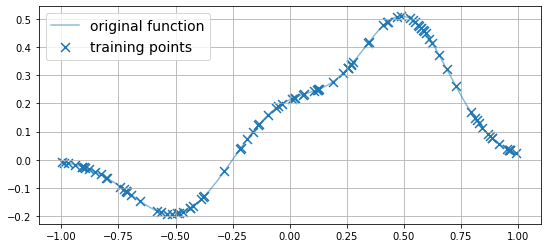

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# data
from MLPR_toolbox.preprocessing import make_Phi_rbf_1d

x_tilde = np.linspace(-1,1,500).reshape(-1,1)
Phi_tilde = make_Phi_rbf_1d(x_tilde, centers=np.array([-0.5,0,0.5]), h=0.2)
w_tilde = np.array([-0.2,0.2,0.5]).reshape(-1,1)

y_tilde = Phi_tilde@w_tilde

np.random.seed(1)
Xy_tilde = np.hstack((x_tilde, y_tilde))

N = 100
idx = np.random.randint(0,501,size=(N,1))
X_train, y_train = Xy_tilde[idx, [0]], Xy_tilde[idx, [1]]

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(x_tilde, y_tilde, alpha=0.5, label='original function')
ax.scatter(X_train, y_train, marker='x', s=80, label='training points')
ax.legend(fontsize=14)
ax.grid()

In [7]:
# test data
M = 50
X_test = np.random.uniform(-1, 1, size=(M,1))
X_test = np.sort(X_test, axis=0)

In [8]:
from MLPR_toolbox.gaussian_processes import GaussianProcess
from MLPR_toolbox.functions import gaussian_kernel

gp = GaussianProcess(X_train)
posterior = gp.posterior(y_train, X_test, gaussian_kernel, 1, 0.2)

y_pred = posterior.rvs(100).mean(axis=0)

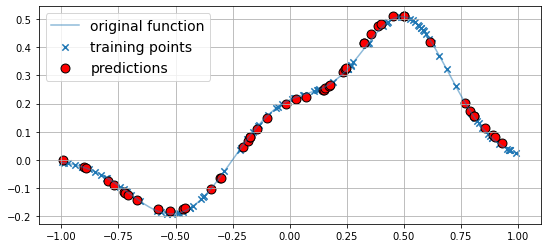

In [9]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(x_tilde, y_tilde, alpha=0.5, label='original function')
ax.scatter(X_train, y_train, marker='x', s=40, label='training points')
ax.scatter(X_test, y_pred, marker='o', color='r', edgecolor='k', s=80, label='predictions')
ax.legend(fontsize=14)
ax.grid()

# Bayesian linear regression test

In [11]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

from MLPR_toolbox.bayesian_models import BayesianLinearRegression
import MLPR_toolbox.preprocessing as prp

N = 500
X, y = make_regression(n_samples=N, n_features=1, bias=5, noise=60, random_state=1)
y = (y / 10).reshape(-1,1)
Phi = prp.make_Phi_polynomial_1d(X, orders=np.array([0,1]))

w0 = np.ones(2).reshape(-1,1)*5
V0 = np.array([[2,0], [0,1/3]])
blm = BayesianLinearRegression(Phi, y, w0, V0)
prior = blm.gaussian_prior()
posterior = blm.gaussian_posterior()

wn = posterior.mean
Vn = posterior.cov

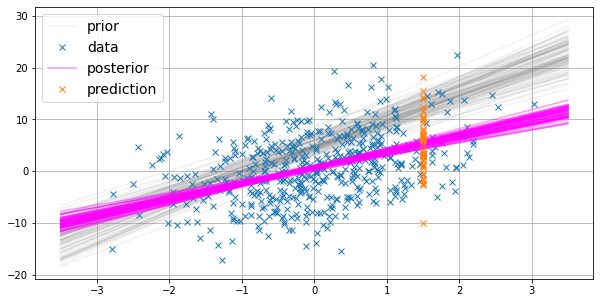

In [12]:
N_pred = 50
X_pred = np.array([[1], [1.5]])
pred_mean, pred_var, pred_dens = blm.prediction_density(X_pred)
x_preds = pred_dens.rvs(N_pred)

fig, ax = plt.subplots(figsize=(10,5))
supp = np.linspace(-3.5, 3.5, 100).reshape(-1,1)
suppX = np.hstack((np.ones((100, 1)), supp))

for _ in range(100):
    prior_params = prior.rvs(1).reshape(-1,1)
    prior_lines, = ax.plot(supp, suppX@prior_params, color='grey', alpha=0.1)

data_lines, = ax.plot(X, y, 'x')

for _ in range(50):
    posterior_params = posterior.rvs(1).reshape(-1,1)
    posterior_lines, = ax.plot(supp, suppX@posterior_params, color='magenta', alpha=0.4)

pred_lines, = ax.plot(np.repeat(X_pred[1], N_pred), x_preds, 'x')

ax.legend([prior_lines, data_lines, posterior_lines, pred_lines], ['prior', 'data', 'posterior', 'prediction'], fontsize=14)
ax.grid()

# Bayes classifier test

In [13]:
import seaborn as sns
import numpy as np

iris_df = sns.load_dataset('iris')
X = iris_df.iloc[:, :4].values
X = prp.standardize(X)

y = iris_df.iloc[:, [-1]]
y = np.where(y=='setosa', 0, np.where(y=='virginica', 2, 1) )

shares = np.array([0.7, 0.29, 0.01])
X_train, X_val, X_test, y_train, y_val, y_test = prp.train_val_test_split(X, y, shares, random_state=1)

In [14]:
from MLPR_toolbox.bayes_classifier import BayesClassifier
    
bc = BayesClassifier(X_train, y_train)
bc.fit(naive=True)
y_pred = bc.predict_labels(X_val)

# compute precision
(y_val==y_pred).sum()/y_val.size

0.9069767441860465

In [15]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.predict(X_val)==y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

# Gradient descent test
## linear regression

In [16]:
import numpy as np

N = 100
x = np.random.normal(1, size=(N,1))
y = 1+2*x+3*x**2 + np.random.normal(size=(N,1))

from MLPR_toolbox.preprocessing import make_Phi_polynomial_1d
Phi = make_Phi_polynomial_1d(x, orders=np.array([0,1,2]))

w_ols = np.linalg.lstsq(Phi, y, rcond=None)[0]
w_ols

array([[1.14040707],
       [1.86089527],
       [3.03557748]])

In [18]:
from MLPR_toolbox.optimizers import GradientDescent
import MLPR_toolbox.functions as fn

Phi = prp.make_Phi_polynomial_1d(x, orders=np.arange(3))
gd = GradientDescent(Phi, y, fn.square_error_gradient, fn.square_loss)

w0 = np.zeros((3,1))
gd.find_weights(w0, eta=0.0001, max_steps=5000, max_loss_diff=1e-10)

stopped after 3150 steps


array([[1.14042712],
       [1.8608662 ],
       [3.03558527]])

## logistic regression